<a href="https://colab.research.google.com/github/tosittig/CASAIS/blob/main/W2_4_1_Pretrained_Classification_4colab_OUTPUT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Classification with a Pretrained Model
In this notebook, we look at text classification again, but will start with a pre-trained BERT model to get an encoding (i.e., a representation).

We will work with a distilbert model, which has similar performance as a full BERT model, but which is more compact (i.e., *distilled*). Also, we will use an uncased version, such that upper and lower case are the same.

## Preparations
We start with installing and importing the necessary modules and loading a dataset. Note that `transformers`, `datasets` (and a few other modules) are made available by Huggingface, a platform to share data and pretrained models.

## Install / update several modules
Some modules are not installed on Google colab by default, you have to install them first (using `pip install <package_name>`)
These modules are not available via Anacanda, so you have to install them firs there.

If you are running this notebook on the student cluster, no installation is needed.

You have to restart the runtime after the following two cells!

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.6 MB/s eta 0:00:00


In [ ]:
!pip install accelerate -U
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 4.2 MB/s eta 0:00:00


In [ ]:
# Modules from huggingface:
from transformers import DistilBertTokenizer

# Tensorflow versions:
from transformers import TFAutoModel, TFAutoModelForSequenceClassification

# PyTorch versions:
from transformers import AutoModel, AutoModelForSequenceClassification

from datasets import load_dataset, DatasetDict

In [ ]:
# More modules for deep learning with tensorflow
import tensorflow as tf

from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# More modules for deep learning with torch
import torch
from transformers import Trainer, TrainingArguments

In [ ]:
# Models for 'standard' machine learning methods
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import balanced_accuracy_score, accuracy_score, f1_score

In [ ]:
# Modules for general functionality:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
# unlimited length of text output
# => will make sure we see the full text to be classified.
pd.set_option('display.max_colwidth', None)

In [ ]:
import pickle

If you are using Google colab, you can set the `use_colab` flag to `True` to save your results to your Google Drive.

In [ ]:
use_colab = False

if use_colab:
    from google.colab import drive
    drive.mount('/content/gdrive', force_remount = True)

In [ ]:
if use_colab:
    targetDir_root = 'gdrive/MyDrive/CAS_AIS_2024_FS/Results/'
    targetDir_models = targetDir_root + 'trainedWeights/'
    targetDir_results = targetDir_root + 'PerformanceMeasures/'

In [ ]:
# define parameters
NUM_LABELS = 6
BATCH_SIZE = 64

## Load and Test the Tokenizer
We load the DistilBert tokenizer from a checkpoint that is made available by Huggingface.

In [ ]:
model_ckpt = "distilbert-base-uncased"
distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

This tokenizer has a vocabulary size of approximately 30'000 tokens and can handle sequences of up to 512 tokens:

In [ ]:
print(distilbert_tokenizer.vocab_size)
print(distilbert_tokenizer.model_max_length)

30522
512


Let's encode a sample text:

In [ ]:
text = "Tokenizing text is a core task of NLP."

In [ ]:
encoded_text = distilbert_tokenizer(text)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


We see that there are more tokens than words. With the function `convert_ids_to_tokens`, we can get the tokens that correspond to the token ids:

In [ ]:
tokens = distilbert_tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']


We see that there are two new tokens: `[CLS]` at the beginning, and `[SEP]` at the end.
* `[CLS]` is an abbreviation for *Classification*. It is used with BERT architectures and essentially serves as a start-of-sentence indicator.
* `[SEP]` separates sentences. BERT was also trained for next-sentence prediction, where 50% of the time, the second sentence is the one that was following the first one in the original text; in 50% of the time, it was a randomly sampled text.

Furthermore, some words have been split into several tokens. The words `text` and `is`, for example, are a token. Some others, however, have been split: `tokenizing` was split into `token` and  `'##izing'`, and `'nlp'` has been split into `'nl'` and `'##p'`.
The `##` prefix in `'##izing'` and `'##p'` means that the preceding string is not whitespace; any token with this prefix should be merged with the previous token when you convert the tokens back to a string. The method `convert_tokens_to_string(tokens)` of the Tokenizer restructs the text from the tokens, and takes care of this merging of subwords:

In [ ]:
print(distilbert_tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp . [SEP]


## The Emotions Dataset
We now move on to the emotions dataset. It is a dictionary with the keys `'train'`, `'validation'` and `'test'`, which each contain `text` and `labels`. The train dataset consists of 16'000 samples, the other two sets have 2'000 samples each. If you run `emotions_raw = load_dataset("emotion")`, you will get the full dataset.

For our example, however, we will use only a subset of the data, as the full dataset causes this notebook to run for a long time, and it might even crash due to an out-of-memory error (the GPU we get from google colab in the free tier has a RAM limit of 15GB). Therefore, we only load the first 2000 samples form the training data, and then split this into 80% training, 10% validation and 10% test data.

In [ ]:
# Loading the dataset
emotions_raw = load_dataset("emotion", split="train[:2000]")

# 80% train, 20% test + validation
train_testvalid = emotions_raw.train_test_split(test_size=0.2)

# Split the 20% test + valid in half test, half valid
test_valid = train_testvalid['test'].train_test_split(test_size=0.5)

# gather everyone if you want to have a single DatasetDict
emotions = DatasetDict({'train': train_testvalid['train'], 'test': test_valid['test'], 'validation': test_valid['train']})

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1461: FutureWarning: The repository for emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/emotion
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1600
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 200
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 200
    })
})

Let us have a look at some of the texts. For this initial analysis, we convert the dataset to pandas format, which makes explorative data analysis very straightforward:

In [ ]:
emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head(10)

,text,label
0,i feel so fucked like everyday of my life,3
1,i saw a few pianos that were either newer cheaper or larger but there was always something missing that made me feel uncertain about buying them,4
2,i get home i laze around in my pajamas feeling grouchy,3
3,im feeling font friendly,1
4,i suddenly feel a lot smarter and more talented than i did last night,1
5,i have an ironic feel i dont feel anything special but i still smile broadly whenever he tells me something,1
6,i feel that rushed prize giving really dilute the event and in future prize givings will be not rushed and will be on timetable,3
7,i was insane not liking someone else to do all this but it made me feel less valuable b c i wasnt working and i also wasnt a housewife,1
8,i lost my special mind but don t worry i m still sane i just wanted you to feel what i felt while reading this book i don t know how many times it was said that sam was special but i can guarantee you it was many more times than what i used in that paragraph did i tell you she was special,1
9,i feel troubled i guess would be the best word for it,0


We add the `label_name` to make the classification more understandable:

In [ ]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df

,text,label,label_name
0,i feel so fucked like everyday of my life,3,anger
1,i saw a few pianos that were either newer cheaper or larger but there was always something missing that made me feel uncertain about buying them,4,fear
2,i get home i laze around in my pajamas feeling grouchy,3,anger
3,im feeling font friendly,1,joy
4,i suddenly feel a lot smarter and more talented than i did last night,1,joy
...,...,...,...
1595,i feel like an impostor in my work as i smile and talk about behavior contracts positive reinforcement cognitive reframing physical activity and other means for diminishing dissolving or deferring the pain of reality,1,joy
1596,i didn t binge at all during the weekend and had more energy to clean the house something i had put off for weeks even if these pills didn t really make me lose any weight i wanted them because i hardly felt the need to eat and didn t feel totally and completely exhausted,0,sadness
1597,i remember a totally different feel having been a faithful dukes watcher growing up,1,joy
1598,i always feel invigorated while listening to her that we can win this war against predatory school deform,1,joy


With the human-readable labels, let us look at how the labels are distributed:

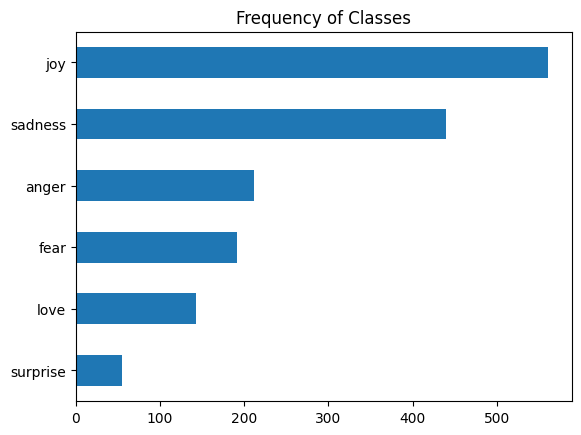

In [ ]:
df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

The labels are quite unevenly distributed - we need to keep this in mind for the further analysis, but don't take any action to get a balanced dataset.

We reset the format of the dataset such that is well-suited to work with the pretrained tokenizers and models:

In [ ]:
del(df) # save memory
emotions.reset_format()

## Tokenizing the Emotions Dataset
Now, we start tokenizing the dataset. We first do 2 sentences:

In [ ]:
emotions["train"]['text'][:2]

['i feel so fucked like everyday of my life',
 'i saw a few pianos that were either newer cheaper or larger but there was always something missing that made me feel uncertain about buying them']

In [ ]:
distilbert_tokenizer(emotions["train"]['text'][:2], padding=True, truncation=True)

{'input_ids': [[101, 1045, 2514, 2061, 21746, 2066, 10126, 1997, 2026, 2166, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2387, 1037, 2261, 27864, 2008, 2020, 2593, 10947, 16269, 2030, 3469, 2021, 2045, 2001, 2467, 2242, 4394, 2008, 2081, 2033, 2514, 9662, 2055, 9343, 2068, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

We have obtained a dictionary with the keys `'input_ids'` and `'attention_mask'`. While the original two sentences have different length, the outputs have been padded with the `[PAD]` token. The `'attention_mask'` is used to ignore the `[PAD]`, i.e. the mask is 0 if the corresponding token is `[PAD]`, and 1 otherwise.

In [ ]:
emotions_tok_01 = distilbert_tokenizer(emotions["train"]['text'][:2], padding=True, truncation=True)

In [ ]:
distilbert_tokenizer.convert_ids_to_tokens(emotions_tok_01['input_ids'][0])

['[CLS]',
 'i',
 'feel',
 'so',
 'fucked',
 'like',
 'everyday',
 'of',
 'my',
 'life',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [ ]:
distilbert_tokenizer.convert_ids_to_tokens(emotions_tok_01['input_ids'][1])

['[CLS]',
 'i',
 'saw',
 'a',
 'few',
 'pianos',
 'that',
 'were',
 'either',
 'newer',
 'cheaper',
 'or',
 'larger',
 'but',
 'there',
 'was',
 'always',
 'something',
 'missing',
 'that',
 'made',
 'me',
 'feel',
 'uncertain',
 'about',
 'buying',
 'them',
 '[SEP]']

With `all_special_tokens` and `all_special_ids`, we can get all the special tokens and their IDs from the tokenizer:

In [ ]:
distilbert_tokenizer.all_special_tokens

['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]']

In [ ]:
distilbert_tokenizer.all_special_ids

[100, 102, 0, 101, 103]

Now, we will tokenize the full emotions dataset. We will again use padding, and also do truncation, i.e. we will cut off the part of the texts that is longer than `distilbert_tokenizer.model_max_length`:

In [ ]:
def tokenize(batch):
    return distilbert_tokenizer(batch["text"], padding=True, truncation=True)
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

## Loading the Pretrained BERT Model
We will use the same model (`distilbert-base-uncased`) and load it from the huggingface repository. We are using `AutoModel`, a class from huggingface that offers a convenient `from_pretrained()` function to get the pre-trained model weights.

In [ ]:
model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

Now, let's define a test text, and pass that through our `distilbert_tokenizer` tokenizer. Note that we add `return_tensors="pt"` to get the input as pytorch tensors (other return types are possible):

In [ ]:
text = "this is a test"
tokenized_text = distilbert_tokenizer(text, return_tensors="pt")
print(f"tokenized_text tensor shape: {tokenized_text['input_ids'].shape}")

tokenized_text tensor shape: torch.Size([1, 6])


Printing the tokenized text, we see the format is different from what we obtained without specifying the `return_tensors`:

In [ ]:
tokenized_text

{'input_ids': <tf.Tensor: shape=(1, 6), dtype=int32, numpy=array([[ 101, 2023, 2003, 1037, 3231,  102]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 6), dtype=int32, numpy=array([[1, 1, 1, 1, 1, 1]], dtype=int32)>}

Now, we pass the tokenized text to the model to get the represenation:

In [ ]:
inputs = {k:v.to(device) for k,v in tokenized_text.items()}
with torch.no_grad():
    represented_text = model(**inputs, output_hidden_states=True)
print(represented_text)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=(tensor([[[ 0.3469, -0.1626, -0.2333,  ...,  0.1487,  0.0865,  0.1422],
         [-0.7254,  0.6949,  0.0031,  ...,  0.3741,  0.2895,  0.4306],
         [-0.8898, -0.2188, -0.4554,  ...,  0.4361,  0.4344,  0.4228],
         [ 0.3343,  0.2545,  0.0149,  ...,  0.3922,  0.0478,  0.5236],
         [ 0.6757, -1.1590, -0.2726,  ...,  0.2656,  0.1224, -2.3736],
         [-0.3386, -0.3936, -0.3539,  ..., -0.3141,  0.4274, -0.1317]]],
       device='cuda:0'), tensor([[[-0.0580, -0.0577, -0.0151,  ...,  0

In [ ]:
represented_text.hidden_states[-1].shape

torch.Size([1, 6, 768])

The resulting tensor has have `[batch_size, n_tokens, hidden_dim]`.
Our batch consists of one line of text, consisting of 6 tokens, and we get a 768-dimensional representation for each of the tokens.

Now, we will convert the full dataset to this representation. To do so, we will add an additional column to the dataset. As our model expects tensorflow tensors, we first convert the relevant columns to this format:

In [ ]:
emotions_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])

We first define a helper function `extract_hidden_states`, which we will then apply to all three splits (`train`, `validation`, and `test`).

Also, for classification tasks, it is common practice to just use the hidden state associated with the `[CLS]` token as the input feature. Since this token appears at the start of each sequence, we can extract it by simply indexing the model output as `last_hidden_state[:, 0, :]` (all texts, first token, all dimensions).

In [ ]:
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in distilbert_tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

Now we are ready to extract the hidden state representation for our training, validation and test set. This is best done in batched mode (as it is much faster). However, by default, the batch size is 1000, which will cause an error when run on a dataset with size that is not a multiple of the batch size (as the index will run out of the valid range for the batch that is not "full"). Hence, we have to specify the `batch_size`.

In [ ]:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True, batch_size=200)

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Now, we have an additional column `'hidden_state'` containing the features that we just computed:

In [ ]:
emotions_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

## Classification with Standard Approaches
In order to be able to compare the performance of the advanced models with some standard techniques, we will evaluate some off-the-shelf classification methods.

### Creating a Feature Matrix
To run standard approaches, we first extract the `'hidden_state'` into a numpy array.

In [ ]:
X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((1600, 768), (200, 768))

In [ ]:
labels = emotions["train"].features["label"].names
labels

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

As a first simple standard approach to classification, let's do logistic regression. While Logistic Regression is by default applicable for binary classification problems (i.e., each sample belongs to one of two classes), the scikit-learn implementation will change the loss function to cross-entropy loss and predict a multinomial probability distribution to support multi-class classification.

In [ ]:
# We increase `max_iter` to guarantee convergence
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.57

In [ ]:
def plot_confusion_matrix(y_true, y_preds, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

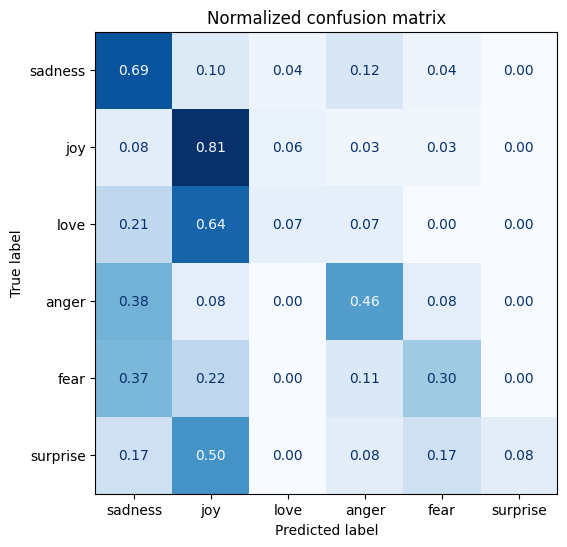

In [ ]:
y_preds_lr = lr_clf.predict(X_valid)
plot_confusion_matrix(y_valid, y_preds_lr, labels)

In [ ]:
bac_logreg = balanced_accuracy_score(y_valid, y_preds_lr)

As a baseline, we also use the `DummyClassifier`, which we configure to always output the most frequent class.

In [ ]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.36

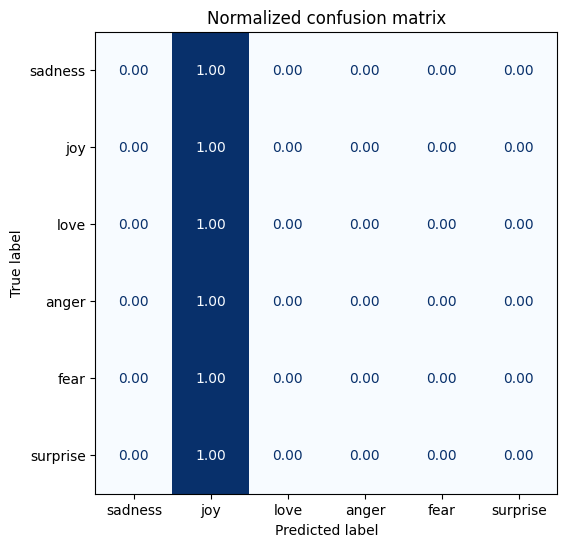

In [ ]:
y_preds_dummy = dummy_clf.predict(X_valid)
plot_confusion_matrix(y_valid, y_preds_dummy, labels)

In [ ]:
bac_dummy = balanced_accuracy_score(y_valid, y_preds_dummy)
bac_dummy

0.16666666666666666

In [ ]:
acc_dummy = accuracy_score(y_valid, y_preds_dummy)
acc_dummy

0.36

As the category *joy* is most frequent, this classifier will always output this label.

### Fine-Tuning the Model
We can use the `Trainer` class (provided by huggingface) to fine-tune the model. This clss abstracts away most of the technical details:

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=NUM_LABELS)
         .to(device))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Nex, we have to define a function to compute the metrics. This function will be used for the `Trainer`, a class (from huggingface) that steers the fine-tuning of the model.

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    bac = balanced_accuracy_score(labels, preds)
    return {"accuracy": acc, "balanced accuracy": bac, "f1": f1}

Using the `Trainer` with `PyTorch` requires `accelerate>=0.20.1`. Therefore, we had to update the `accelerate` in the beginning of the notebook. We first specify the training parameters:

In [ ]:
logging_steps = len(emotions_encoded["train"]) // BATCH_SIZE
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=20,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=BATCH_SIZE,
                                  per_device_eval_batch_size=BATCH_SIZE,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  # set to True to use your model afterwards:
                                  push_to_hub=False,
                                  log_level="error")

Now, we can use the `Trainer` class to train the model with the specified parameters:

In [ ]:
trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=distilbert_tokenizer)
trainer.train();

Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1
1,1.615000,1.500606,0.500000,0.264078,0.372398
2,1.309900,1.127267,0.575000,0.316185,0.444696
3,1.026900,0.942943,0.665000,0.426899,0.592272
4,0.804900,0.748775,0.745000,0.568567,0.709610
5,0.571800,0.580356,0.805000,0.696671,0.792875
6,0.406700,0.487827,0.850000,0.800999,0.847863
7,0.294200,0.401145,0.870000,0.834493,0.869078
8,0.209600,0.342341,0.895000,0.869280,0.894253
9,0.155200,0.310061,0.890000,0.873357,0.890131
10,0.114400,0.267334,0.935000,0.911184,0.934558


Accuracy and F1-score are computed on the validation data. Note that the data set is -- in comparison to the model complexity -- very small and might cause our model to start to overfit.

We can now evaluate the performance of the fine-tuned model on the validation set:

In [ ]:
preds_output = trainer.predict(emotions_encoded["validation"])
preds_output.metrics

{'test_loss': 0.2741583585739136,
 'test_accuracy': 0.92,
 'test_balanced accuracy': 0.8990578425102234,
 'test_f1': 0.9196071924804792,
 'test_runtime': 0.3676,
 'test_samples_per_second': 544.03,
 'test_steps_per_second': 10.881}

To get a more detailed view on the classification performance, we also look at the confusion matrix:

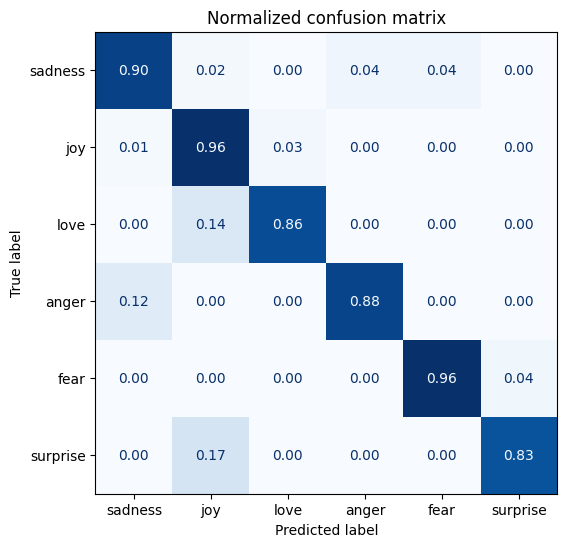

In [ ]:
y_preds = np.argmax(preds_output.predictions, axis=1)
plot_confusion_matrix(y_valid, y_preds, labels)

In [ ]:
bac_ft_pt = balanced_accuracy_score(y_valid, y_preds)
bac_ft_pt

0.8990578425102234

We see that the category *love* are quite often confused with *joy*, which seems natural. *joy* and *fear* are the categories that are best recognised.

## Error Analysis
In order to better understand the performance of our model, we will investigate some samples of the validation data set. More specifically, we will look at the examples where the loss was particularly high or low.

To get the loss, we run the model again on the sentences, and then calculate the estimated label and the cross-entropy.

In [ ]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in distilbert_tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device),
                             reduction="none")
    # Place outputs on CPU for compatibility with other dataset columns
    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()}

In [ ]:
# Convert our dataset back to PyTorch tensors
emotions_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])
# Compute loss values
emotions_encoded["validation"] = emotions_encoded["validation"].map(
    forward_pass_with_label, batched=True, batch_size=16)

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

We convert the emotions dataframe to pandas, and convert the numerical categories to text labels:

In [ ]:
emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(label_int2str))

Now, we can look at the 10 examples with the highest loss:

In [ ]:
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
168,i love a movie with a good feel to it that really keeps you enthralled and the road has just that,surprise,joy,6.153619
103,i was feeling pretty wiped out mentally amp physically i was determined to get some oxygen to my brain,joy,sadness,6.135379
28,i think we i can get caught up in the nature of being busy of feeling the need to fill each moment with industry of some sort of occupying blank spaces with effort and chores,sadness,joy,4.818785
81,im feeling like life is fairly sweet,love,joy,4.421042
25,i havent worked out today but i feel like im just not going to feel it ive been so stressed at work and just in life that this week is just bad,anger,sadness,4.201218
26,i wonder are you jealous or feeling of discontent or covetousnes,sadness,anger,3.743126
177,i feel like i should have actively hated every single second rather than just borne it all,anger,sadness,3.157366
188,i do not feel overwhelmed nor rushed,fear,surprise,2.808330
161,im feeling generous again here it is in its entirety for free consumption,joy,love,2.275388
24,i will spend my vacation on me no obligations no headaches no feeling like i am being emotional blackmailed into being three places at once,sadness,anger,2.072880


Conversely, here are the 10 examples with lowest loss - i.e., where the model is most confident about its prediction:

In [ ]:
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
173,i am so feeling so rich and yup i know i am so blessed,joy,joy,0.005081
176,i feel as a child innocent feelings illustrating a,joy,joy,0.005209
49,i love the rainbow look that i have going on and think that it feels really festive i just hope the kids don t feel like it s suppose to be a constant party in our classroom thanks to the tissue paper balls,joy,joy,0.005279
126,i am bloging again i am sitting here feeling content with my dogs amp cat etc and i know that how lucky we are the truth is we,joy,joy,0.005416
163,i want people to feel brave and i want society to accept us as disabled people amongst us who deserve dignity and respect not to be shunned and laughed at,joy,joy,0.005437
139,i feel privileged to have narrated erik princes autobiography civilian warriors the inside story of blackwater and the unsung heroes of the war on terror which will be released this monday nov th,joy,joy,0.005462
149,i hope that you realize how such little effort is required to make a person feel better about themselves or their situation whether its me a family member a college or high school friend a neighbor down the street or even a complete stranger,joy,joy,0.005584
72,i feel so honoured to have hosted this series to have such talented a,joy,joy,0.005607
187,im not feeling terribly adventurous plus i have family visiting so i cant completely neglect them meaning its going to be business as usual for me,joy,joy,0.005614
22,im feeling a little bit more positive now as things were quite hard at first as my savings were eaten up quickly with costs and i didnt want to become a burden to my boyfriend but weve come out the other end and im feeling brighter and more inspired about things to come,joy,joy,0.005648


Doing some error analysis like this allows us to identify potential issues in the data labels - or to confirm model weaknesses.